Домашнее задание
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [75]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import catboost as catb
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

In [76]:
df = pd.read_csv('weatherAUS.csv', sep=',')
df.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No


In [77]:
df.shape

(145460, 23)

In [78]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [79]:
# Посомтрим на пропуски

df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [80]:
# Посмотрим на типы данных в датасете

df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [81]:
target_name = 'RainTomorrow'
base_feature_names = df.columns.drop([target_name]).tolist()
cat_feature_names = df.select_dtypes(include='object').columns.drop([target_name]).tolist()
num_feature_names = df.columns.drop([target_name] + cat_feature_names).tolist()

In [82]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [83]:
# преобразуем target

df.loc[df['RainTomorrow'] == 'No', 'RainTomorrow'] = 0
df.loc[df['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1

In [84]:
df['RainTomorrow'].unique()

array([0, 1, nan], dtype=object)

In [85]:
df['RainTomorrow'].isna().sum()

3267

In [86]:
#выкинем  значения, где наш таргет неопределен

df = df[df['RainTomorrow'].notna()]

In [87]:
# поменяем тип данных у target

df = df.astype({"RainTomorrow": int})

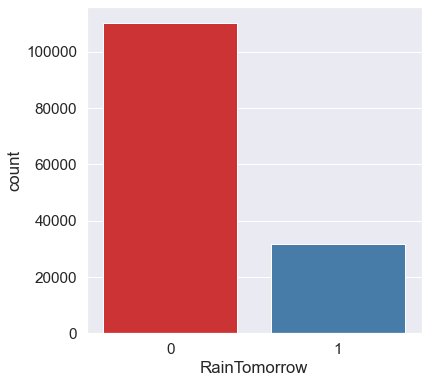

In [88]:
#Посмотрим на соотношение классов 

f, ax = plt.subplots(figsize=(6, 6))
ax = sns.countplot(x="RainTomorrow", data=df, palette="Set1")
plt.show()

In [89]:
#Посмотрим на соотношение классов в численном выражении

df['RainTomorrow'].value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

### Корреляция целевой переменной с базовыми признаками

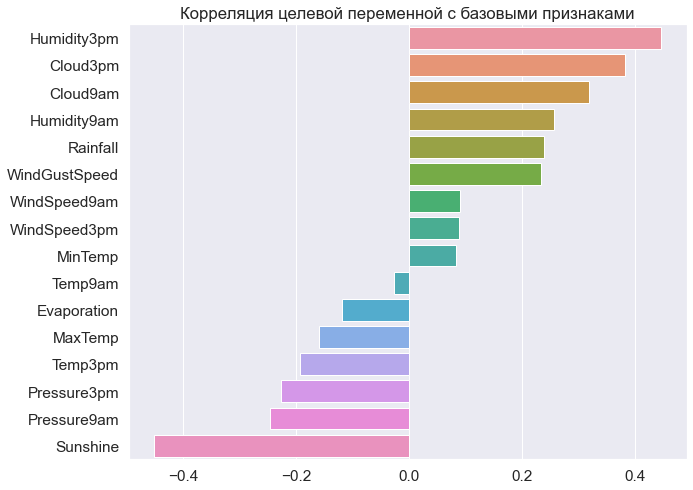

In [90]:
corr_with_target = df[base_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция целевой переменной с базовыми признаками')
plt.show()

### Матрица корреляций признаков

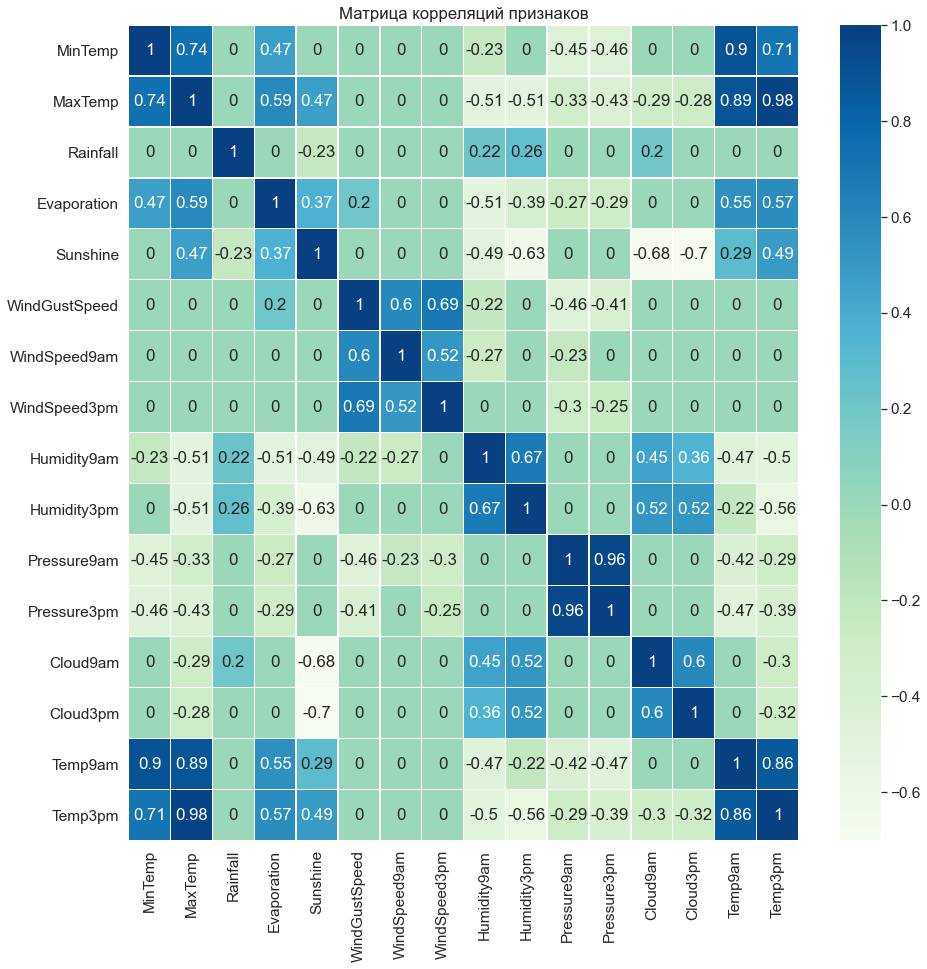

In [91]:
plt.figure(figsize = (15,15))

sns.set(font_scale=1.4)

corr_matrix = df[base_feature_names].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляций признаков')
plt.show()

### Анализ выбросов

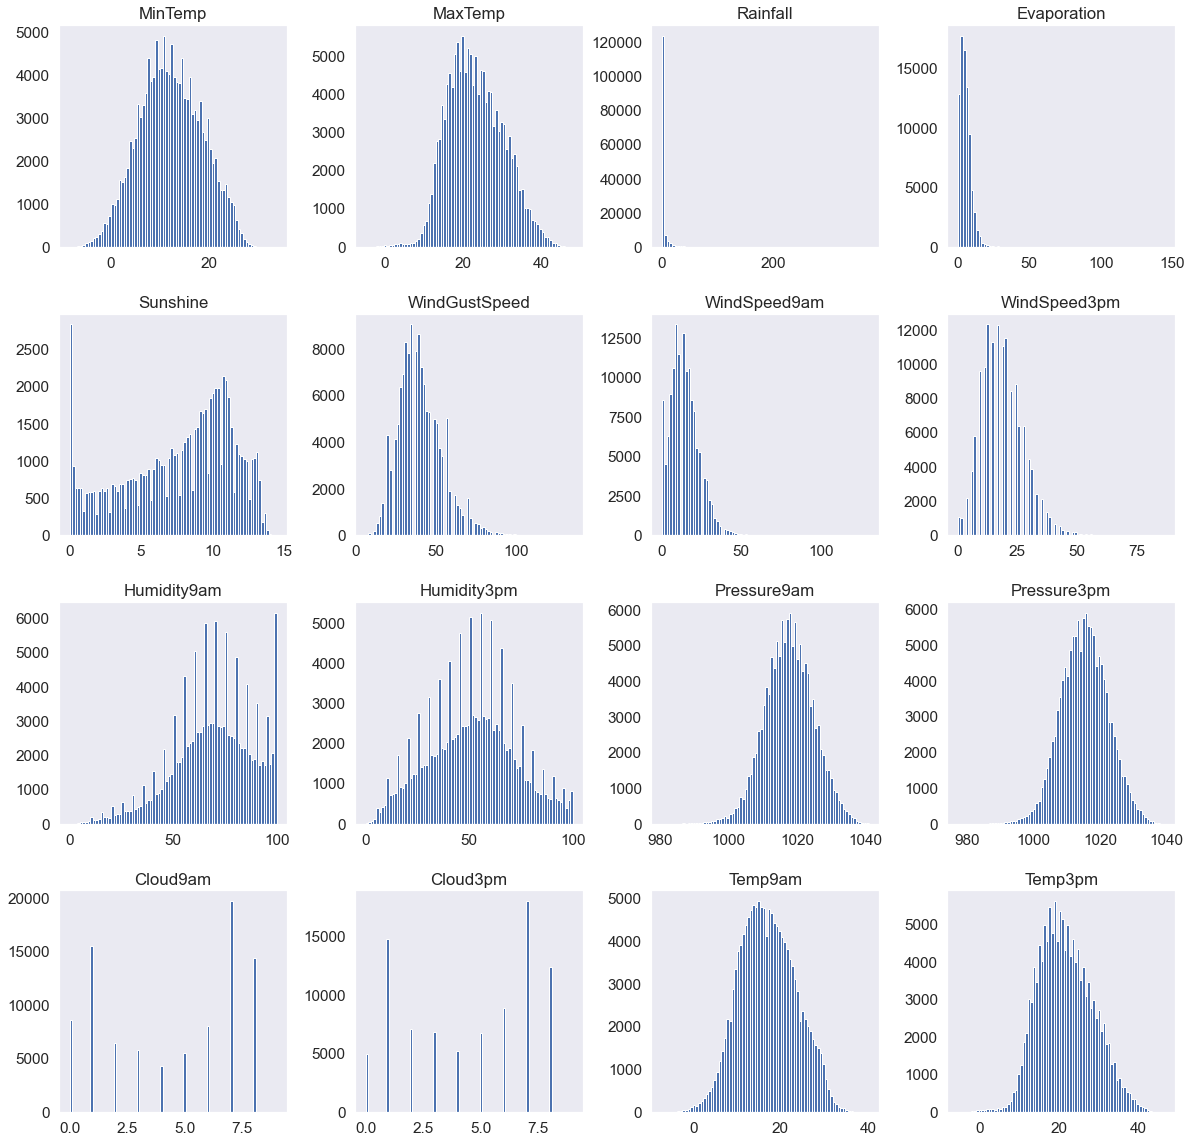

In [92]:
df[num_feature_names].hist(figsize=(20, 20), bins=80, grid=False);

In [93]:
# посомтрим на сводную статистику в числовыхпеременных

print(round(df[num_feature_names].describe()),2)

        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  141556.0  141871.0  140787.0      81350.0   74377.0       132923.0   
mean       12.0      23.0       2.0          5.0       8.0           40.0   
std         6.0       7.0       8.0          4.0       4.0           14.0   
min        -8.0      -5.0       0.0          0.0       0.0            6.0   
25%         8.0      18.0       0.0          3.0       5.0           31.0   
50%        12.0      23.0       0.0          5.0       8.0           39.0   
75%        17.0      28.0       1.0          7.0      11.0           48.0   
max        34.0      48.0     371.0        145.0      14.0          135.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
count      140845.0      139563.0     140419.0     138583.0     128179.0   
mean           14.0          19.0         69.0         51.0       1018.0   
std             9.0           9.0         19.0         21.0          7.0   
mi

In [94]:
# обработаем пропущенные значения числовых признаков в df

for col in df[num_feature_names]:
    col_median = df[col].median()
    df[col].fillna(col_median, inplace=True) 

In [95]:
# проверим наличие пропусков еще раз df
df[num_feature_names].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [96]:
# проверка количества элементов в категориальных переменных

for var in cat_feature_names:
    
    print(var, ' содержит ', len(df[var].unique()), ' labels')

Date  содержит  3436  labels
Location  содержит  49  labels
WindGustDir  содержит  17  labels
WindDir9am  содержит  17  labels
WindDir3pm  содержит  17  labels
RainToday  содержит  3  labels


In [97]:
# обработаем признак RainToday

df['RainToday'].fillna(df['RainToday'].mode()[0], inplace=True)

# переведем признак RainToday в числовой
df.loc[df['RainToday'] == 'No', 'RainToday'] = 0
df.loc[df['RainToday'] == 'Yes', 'RainToday'] = 1
df['RainToday'].unique()
df = df.astype({"RainToday": int})

Мы видим, что есть переменная типа Date, которую нужно предварительно обработать.

In [98]:
# приведем фичу Date к нормальному формату даты 

df['Date'] = pd.to_datetime(df['Date'])

In [99]:
# извлечь год, месяц и день из числа

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [100]:
# удалим столбец Date

df.drop('Date', axis=1, inplace = True)

In [101]:
df.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,4.8,8.5,W,44.0,W,WNW,...,1007.1,8.0,5.0,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,4.8,8.5,WNW,44.0,NNW,WSW,...,1007.8,5.0,5.0,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,4.8,8.5,WSW,46.0,W,WSW,...,1008.7,5.0,2.0,21.0,23.2,0,0,2008,12,3


In [102]:
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday          int32
RainTomorrow       int32
Year               int64
Month              int64
Day                int64
dtype: object

In [103]:
# Обновим наши список наших категориальных фичей, чтобы в нем не было даты, 
#которая была типом "object"
cat_feature_names = df.select_dtypes(include='object').columns.tolist()
cat_feature_names

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

In [104]:
# вывести процент пропущенных значений в категориальных переменных в df

df[cat_feature_names].isnull().mean()

Location       0.000000
WindGustDir    0.065615
WindDir9am     0.070418
WindDir3pm     0.026570
dtype: float64

In [105]:
# присвоим отсутствующим категориальным переменным наиболее частое значение

df['WindGustDir'].fillna(df['WindGustDir'].mode()[0], inplace=True)
df['WindDir9am'].fillna(df['WindDir9am'].mode()[0], inplace=True)
df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0], inplace=True)

In [106]:
#кодируем все категориальные признаки с помощью get_dummies
df = pd.get_dummies(df, columns = cat_feature_names, prefix_sep = "_", drop_first = True) 

In [107]:
X = df.drop(columns=target_name)
y = df[target_name]

In [108]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [109]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((99535, 113), (42658, 113), (99535,), (42658,))

In [129]:
catb_model = catb.CatBoostClassifier(
    random_state=42,  
    n_estimators=1000, 
    learning_rate=0.025,
#     cat_features = cat_feature_names
)

catb_model.fit(X_train, y_train)
y_predict = catb_model.predict(X_valid)

0:	learn: 0.6746431	total: 15.3ms	remaining: 15.3s
1:	learn: 0.6575133	total: 31.3ms	remaining: 15.6s
2:	learn: 0.6409602	total: 46.8ms	remaining: 15.5s
3:	learn: 0.6253139	total: 62.4ms	remaining: 15.5s
4:	learn: 0.6114262	total: 78.7ms	remaining: 15.7s
5:	learn: 0.5977598	total: 93.9ms	remaining: 15.6s
6:	learn: 0.5850834	total: 110ms	remaining: 15.6s
7:	learn: 0.5737274	total: 126ms	remaining: 15.7s
8:	learn: 0.5629014	total: 141ms	remaining: 15.6s
9:	learn: 0.5526471	total: 156ms	remaining: 15.5s
10:	learn: 0.5431766	total: 172ms	remaining: 15.4s
11:	learn: 0.5333279	total: 188ms	remaining: 15.5s
12:	learn: 0.5246043	total: 202ms	remaining: 15.4s
13:	learn: 0.5158059	total: 221ms	remaining: 15.6s
14:	learn: 0.5080916	total: 239ms	remaining: 15.7s
15:	learn: 0.5005550	total: 255ms	remaining: 15.7s
16:	learn: 0.4929785	total: 271ms	remaining: 15.7s
17:	learn: 0.4865398	total: 287ms	remaining: 15.7s
18:	learn: 0.4805459	total: 303ms	remaining: 15.7s
19:	learn: 0.4746367	total: 319ms	r

In [130]:
# посмоттрим на метрики

results = {}

def evaluate_results(y_valid, y_predict):

    f1 = f1_score(y_valid, y_predict)
    roc = roc_auc_score(y_valid, y_predict)
    rec = recall_score(y_valid, y_predict, average='binary')
    prc = precision_score(y_valid, y_predict, average='binary')
    results = {'metric': ['f1_score', 'roc_auc_score', 'recall', 'precision'],
               'catboost_model': [f1, roc, rec, prc],
              }

    return results

In [131]:
models_results = evaluate_results(y_valid, y_predict)
models_results

{'metric': ['f1_score', 'roc_auc_score', 'recall', 'precision'],
 'catboost_model': [0.6302790812546307,
  0.744279390000042,
  0.5358530183727034,
  0.7651026832558837]}

In [133]:
# скопируем наш датасет
mod_df = df.copy()

#добавим тестовый признак
mod_df['class_test'] = 0

# беру только RainTomorrow = 1
mod_df_P = mod_df.loc[mod_df['RainTomorrow'] == 1]
mod_df_N = mod_df.loc[mod_df['RainTomorrow'] == 0]

# делю датафрейм 70 на 30 и перемешиваю его 
mod_df_P_70, mod_df_P_30 = train_test_split(mod_df_P, test_size=0.3, shuffle=True, random_state=42)

# беру кусочек 30% и заменяю в нем значения class_test на 1, там где RainTomorrow = 1
mod_df_P_30.loc[mod_df_P_30['RainTomorrow'] == 1, 'class_test'] = 1
mod_df_P_30.head(5)

C:\Users\kosfo\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,class_test
126713,17.2,26.0,0.6,4.8,8.5,44.0,11.0,13.0,85.0,64.0,...,0,0,1,0,0,0,0,0,0,1
120998,9.5,16.6,0.6,1.2,0.1,41.0,11.0,15.0,89.0,86.0,...,0,0,0,0,0,0,0,0,0,1
20516,17.0,23.4,0.0,4.8,8.5,50.0,17.0,35.0,86.0,82.0,...,0,0,0,0,0,0,0,0,0,1
63805,11.3,14.9,9.6,4.8,8.5,35.0,9.0,6.0,99.0,98.0,...,0,0,0,1,0,0,0,0,0,1
41951,16.1,19.9,11.4,14.6,3.6,41.0,22.0,15.0,83.0,79.0,...,0,0,0,0,0,0,0,0,0,1


In [134]:
mod_df_N.shape, mod_df_P_70.shape, mod_df_P_30.shape

((110316, 115), (22313, 115), (9564, 115))

In [135]:
mod_df = pd.concat([mod_df_P_30, mod_df_P_70, mod_df_N],axis=0)
mod_df.shape

(142193, 115)

In [136]:
# поменяем расстановку столбцов для удобства

mod_df = mod_df[[c for c in mod_df if c not in ['RainTomorrow', 'class_test']] 
       + ['RainTomorrow', 'class_test']]
mod_df

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainTomorrow,class_test
126713,17.2,26.0,0.6,4.8,8.5,44.0,11.0,13.0,85.0,64.0,...,0,1,0,0,0,0,0,0,1,1
120998,9.5,16.6,0.6,1.2,0.1,41.0,11.0,15.0,89.0,86.0,...,0,0,0,0,0,0,0,0,1,1
20516,17.0,23.4,0.0,4.8,8.5,50.0,17.0,35.0,86.0,82.0,...,0,0,0,0,0,0,0,0,1,1
63805,11.3,14.9,9.6,4.8,8.5,35.0,9.0,6.0,99.0,98.0,...,0,0,1,0,0,0,0,0,1,1
41951,16.1,19.9,11.4,14.6,3.6,41.0,22.0,15.0,83.0,79.0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,4.8,8.5,31.0,15.0,13.0,59.0,27.0,...,0,0,0,0,0,0,0,0,0,0
145455,2.8,23.4,0.0,4.8,8.5,31.0,13.0,11.0,51.0,24.0,...,0,0,0,0,0,0,0,0,0,0
145456,3.6,25.3,0.0,4.8,8.5,22.0,13.0,9.0,56.0,21.0,...,0,0,0,0,0,0,0,0,0,0
145457,5.4,26.9,0.0,4.8,8.5,37.0,9.0,9.0,53.0,24.0,...,0,0,0,0,0,0,1,0,0,0


In [137]:
mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['class_test']==0][:len(mod_df[mod_df['class_test']==1])]
sample_test = mod_df[mod_df['class_test']==0][len(mod_df[mod_df['class_test']==1]):]
pos_sample = mod_df[mod_df['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(9564, 115) (9564, 115)


In [138]:
model = catb.CatBoostClassifier(
    random_state=42,  
    n_estimators=1200, 
    learning_rate=0.025,
)

In [139]:
model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)

0:	learn: 0.6817913	total: 9.45ms	remaining: 11.3s
1:	learn: 0.6710493	total: 17.6ms	remaining: 10.5s
2:	learn: 0.6622188	total: 25.6ms	remaining: 10.2s
3:	learn: 0.6528057	total: 33.6ms	remaining: 10s
4:	learn: 0.6428350	total: 41.3ms	remaining: 9.87s
5:	learn: 0.6350251	total: 49.1ms	remaining: 9.77s
6:	learn: 0.6266281	total: 56.8ms	remaining: 9.69s
7:	learn: 0.6193876	total: 64.7ms	remaining: 9.64s
8:	learn: 0.6126318	total: 72.5ms	remaining: 9.59s
9:	learn: 0.6054466	total: 79.9ms	remaining: 9.51s
10:	learn: 0.5988302	total: 87.7ms	remaining: 9.48s
11:	learn: 0.5921018	total: 95.6ms	remaining: 9.46s
12:	learn: 0.5864161	total: 104ms	remaining: 9.45s
13:	learn: 0.5812039	total: 111ms	remaining: 9.43s
14:	learn: 0.5759663	total: 119ms	remaining: 9.41s
15:	learn: 0.5704761	total: 127ms	remaining: 9.37s
16:	learn: 0.5651818	total: 134ms	remaining: 9.35s
17:	learn: 0.5600923	total: 142ms	remaining: 9.34s
18:	learn: 0.5551471	total: 150ms	remaining: 9.32s
19:	learn: 0.5512242	total: 158

In [140]:
# посчитаем на метрики

results = {}

def evaluate_results_rns(y_valid, y_predict):

    f1 = f1_score(y_valid, y_predict)
    roc = roc_auc_score(y_valid, y_predict)
    rec = recall_score(y_valid, y_predict, average='binary')
    prc = precision_score(y_valid, y_predict, average='binary')
    results = {'metric': ['f1_score', 'roc_auc_score', 'recall', 'precision'],
               'rns_model': [f1, roc, rec, prc],
              }

    return results

In [141]:
results_rns_model = evaluate_results_rns(sample_test.iloc[:,-2].values, y_predict)
models_results['rns_model'] = results_rns_model['rns_model']

In [142]:
result_df = pd.DataFrame(models_results)
result_df

,metric,catboost_model,rns_model
0,f1_score,0.630279,0.543910
1,roc_auc_score,0.744279,0.796895
2,recall,0.535853,0.853095
3,precision,0.765103,0.399222


In [148]:
### поменяем объем выборки при делении датасета на 20%

# скопируем наш датасет
mod_df = df.copy()

#добавим тестовый признак
mod_df['class_test'] = 0

# беру только RainTomorrow = 1
mod_df_P = mod_df.loc[mod_df['RainTomorrow'] == 1]
mod_df_N = mod_df.loc[mod_df['RainTomorrow'] == 0]

# делю датафрейм 70 на 30 и перемешиваю его 
mod_df_P_70, mod_df_P_30 = train_test_split(mod_df_P, test_size=0.2, shuffle=True, random_state=42)

# беру кусочек 30% и заменяю в нем значения class_test на 1, там где RainTomorrow = 1
mod_df_P_30.loc[mod_df_P_30['RainTomorrow'] == 1, 'class_test'] = 1

mod_df = pd.concat([mod_df_P_30, mod_df_P_70, mod_df_N],axis=0)

# поменяем расстановку столбцов для удобства

mod_df = mod_df[[c for c in mod_df if c not in ['RainTomorrow', 'class_test']] 
       + ['RainTomorrow', 'class_test']]

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['class_test']==0][:len(mod_df[mod_df['class_test']==1])]
sample_test = mod_df[mod_df['class_test']==0][len(mod_df[mod_df['class_test']==1]):]
pos_sample = mod_df[mod_df['class_test']==1]
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

model = catb.CatBoostClassifier(
    random_state=42,  
    n_estimators=1200, 
    learning_rate=0.025,
)

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)

results_rns_model = evaluate_results_rns(sample_test.iloc[:,-2].values, y_predict)
models_results['rns_model_20%'] = results_rns_model['rns_model']

C:\Users\kosfo\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0:	learn: 0.6815948	total: 7.69ms	remaining: 9.22s
1:	learn: 0.6708133	total: 15ms	remaining: 9.01s
2:	learn: 0.6593236	total: 22.4ms	remaining: 8.94s
3:	learn: 0.6502177	total: 29.6ms	remaining: 8.86s
4:	learn: 0.6404687	total: 37.2ms	remaining: 8.9s
5:	learn: 0.6310640	total: 44.5ms	remaining: 8.85s
6:	learn: 0.6226733	total: 51.8ms	remaining: 8.83s
7:	learn: 0.6147269	total: 59.4ms	remaining: 8.85s
8:	learn: 0.6068795	total: 66.5ms	remaining: 8.8s
9:	learn: 0.5995039	total: 73.5ms	remaining: 8.75s
10:	learn: 0.5927119	total: 80.8ms	remaining: 8.73s
11:	learn: 0.5860312	total: 87.8ms	remaining: 8.69s
12:	learn: 0.5798085	total: 94.7ms	remaining: 8.65s
13:	learn: 0.5742146	total: 102ms	remaining: 8.63s
14:	learn: 0.5692324	total: 109ms	remaining: 8.6s
15:	learn: 0.5630754	total: 116ms	remaining: 8.59s
16:	learn: 0.5574078	total: 123ms	remaining: 8.57s
17:	learn: 0.5530586	total: 130ms	remaining: 8.55s
18:	learn: 0.5479671	total: 137ms	remaining: 8.53s
19:	learn: 0.5437864	total: 144ms

In [149]:
## попробуем взять 40% выборки

# скопируем наш датасет
mod_df = df.copy()

#добавим тестовый признак
mod_df['class_test'] = 0

# беру только RainTomorrow = 1
mod_df_P = mod_df.loc[mod_df['RainTomorrow'] == 1]
mod_df_N = mod_df.loc[mod_df['RainTomorrow'] == 0]

# делю датафрейм 70 на 30 и перемешиваю его 
mod_df_P_70, mod_df_P_30 = train_test_split(mod_df_P, test_size=0.4, shuffle=True, random_state=42)

# беру кусочек 30% и заменяю в нем значения class_test на 1, там где RainTomorrow = 1
mod_df_P_30.loc[mod_df_P_30['RainTomorrow'] == 1, 'class_test'] = 1

mod_df = pd.concat([mod_df_P_30, mod_df_P_70, mod_df_N],axis=0)

# поменяем расстановку столбцов для удобства

mod_df = mod_df[[c for c in mod_df if c not in ['RainTomorrow', 'class_test']] 
       + ['RainTomorrow', 'class_test']]

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['class_test']==0][:len(mod_df[mod_df['class_test']==1])]
sample_test = mod_df[mod_df['class_test']==0][len(mod_df[mod_df['class_test']==1]):]
pos_sample = mod_df[mod_df['class_test']==1]
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

model = catb.CatBoostClassifier(
    random_state=42,  
    n_estimators=1200, 
    learning_rate=0.025,
)

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)

results_rns_model = evaluate_results_rns(sample_test.iloc[:,-2].values, y_predict)
models_results['rns_model_40%'] = results_rns_model['rns_model']

C:\Users\kosfo\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0:	learn: 0.6818070	total: 8.77ms	remaining: 10.5s
1:	learn: 0.6715360	total: 17.9ms	remaining: 10.7s
2:	learn: 0.6618215	total: 26ms	remaining: 10.4s
3:	learn: 0.6523427	total: 35.1ms	remaining: 10.5s
4:	learn: 0.6434997	total: 43.8ms	remaining: 10.5s
5:	learn: 0.6349978	total: 52.6ms	remaining: 10.5s
6:	learn: 0.6267523	total: 61.3ms	remaining: 10.5s
7:	learn: 0.6190016	total: 69.4ms	remaining: 10.3s
8:	learn: 0.6115018	total: 77.9ms	remaining: 10.3s
9:	learn: 0.6044209	total: 86.4ms	remaining: 10.3s
10:	learn: 0.5980859	total: 95ms	remaining: 10.3s
11:	learn: 0.5909227	total: 104ms	remaining: 10.3s
12:	learn: 0.5846614	total: 112ms	remaining: 10.2s
13:	learn: 0.5792139	total: 121ms	remaining: 10.2s
14:	learn: 0.5738038	total: 129ms	remaining: 10.2s
15:	learn: 0.5683722	total: 137ms	remaining: 10.1s
16:	learn: 0.5630791	total: 146ms	remaining: 10.1s
17:	learn: 0.5586997	total: 154ms	remaining: 10.1s
18:	learn: 0.5544877	total: 163ms	remaining: 10.1s
19:	learn: 0.5505774	total: 172ms	

In [151]:
## попробуем взять 10% выборки

# скопируем наш датасет
mod_df = df.copy()

#добавим тестовый признак
mod_df['class_test'] = 0

# беру только RainTomorrow = 1
mod_df_P = mod_df.loc[mod_df['RainTomorrow'] == 1]
mod_df_N = mod_df.loc[mod_df['RainTomorrow'] == 0]

# делю датафрейм 70 на 30 и перемешиваю его 
mod_df_P_70, mod_df_P_30 = train_test_split(mod_df_P, test_size=0.1, shuffle=True, random_state=42)

# беру кусочек 30% и заменяю в нем значения class_test на 1, там где RainTomorrow = 1
mod_df_P_30.loc[mod_df_P_30['RainTomorrow'] == 1, 'class_test'] = 1

mod_df = pd.concat([mod_df_P_30, mod_df_P_70, mod_df_N],axis=0)

# поменяем расстановку столбцов для удобства

mod_df = mod_df[[c for c in mod_df if c not in ['RainTomorrow', 'class_test']] 
       + ['RainTomorrow', 'class_test']]

mod_df = mod_df.sample(frac=1)
neg_sample = mod_df[mod_df['class_test']==0][:len(mod_df[mod_df['class_test']==1])]
sample_test = mod_df[mod_df['class_test']==0][len(mod_df[mod_df['class_test']==1]):]
pos_sample = mod_df[mod_df['class_test']==1]
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

model = catb.CatBoostClassifier(
    random_state=42,  
    n_estimators=1200, 
    learning_rate=0.025,
)

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)

results_rns_model = evaluate_results_rns(sample_test.iloc[:,-2].values, y_predict)
models_results['rns_model_10%'] = results_rns_model['rns_model']

C:\Users\kosfo\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


0:	learn: 0.6822537	total: 4.4ms	remaining: 5.27s
1:	learn: 0.6724199	total: 8.77ms	remaining: 5.25s
2:	learn: 0.6626470	total: 13.4ms	remaining: 5.33s
3:	learn: 0.6530478	total: 17.5ms	remaining: 5.24s
4:	learn: 0.6441474	total: 21.9ms	remaining: 5.24s
5:	learn: 0.6361903	total: 26.2ms	remaining: 5.21s
6:	learn: 0.6292594	total: 30.5ms	remaining: 5.2s
7:	learn: 0.6220171	total: 34.8ms	remaining: 5.19s
8:	learn: 0.6151273	total: 39.1ms	remaining: 5.17s
9:	learn: 0.6081971	total: 43ms	remaining: 5.11s
10:	learn: 0.6022565	total: 46.8ms	remaining: 5.06s
11:	learn: 0.5955131	total: 50.7ms	remaining: 5.01s
12:	learn: 0.5898821	total: 54.5ms	remaining: 4.97s
13:	learn: 0.5831089	total: 58.3ms	remaining: 4.94s
14:	learn: 0.5782919	total: 62.1ms	remaining: 4.91s
15:	learn: 0.5730298	total: 66ms	remaining: 4.89s
16:	learn: 0.5677274	total: 70.1ms	remaining: 4.88s
17:	learn: 0.5625872	total: 74ms	remaining: 4.86s
18:	learn: 0.5581375	total: 77.9ms	remaining: 4.84s
19:	learn: 0.5541652	total: 82

In [152]:
result_df = pd.DataFrame(models_results)
result_df

,metric,catboost_model,rns_model,rns_model_40%,rns_model_20%,rns_model_10%
0,f1_score,0.630279,0.517696,0.519822,0.568084,0.580945
1,roc_auc_score,0.744279,0.799783,0.801179,0.793618,0.785588
2,recall,0.535853,0.846457,0.847225,0.853842,0.854334
3,precision,0.765103,0.372874,0.374933,0.425635,0.440109


Вывод: при применении random negative sampling для построения классификатора получили падение точности (precision) при всех вариантах разбиения выборки; recall значительно подрос; если судить об f1-мере, то видим небольшое падение. 

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ответ: на практике, безусловно, лучше пользоваться методом 2-step approach, т.к. можем контролировать порог отнесения к негативным и позитивным классам 